## CS6700: Reinforcement Learning - Tutorial 4 (Q-Learning and SARSA)

Your tasks are as follows:

1. Complete code for $\epsilon$-greedy and softmax action selection policy
2. Complete update equation for SARSA - train and visualize an agent
3. Analyze performance of SARSA - Plot total reward & steps taken per episode (averaged across 5 runs)
4. Complete update equation for Q-Learning - train and visualize an agent
5. Analyze performance of Q-Learning - Plot total reward & steps taken per episode (averaged across 5 runs)

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
%matplotlib inline

# Problem Statement

In this section we will implement tabular SARSA and Q-learning algorithms for a grid world navigation task.

## Environment details
The agent can move from one grid coordinate to one of its adjacent grids using one of the four actions: UP, DOWN, LEFT and RIGHT. The goal is to go from a randomly assigned starting position to goal position.

Actions that can result in taking the agent off the grid will not yield any effect.
Lets look at the environment.


In [33]:
DOWN = 0
UP = 1
LEFT = 2
RIGHT = 3
actions = [DOWN, UP, LEFT, RIGHT]

Let us construct a grid in a text file.

In [34]:
# It will work in unix or macos system
# !cat grid_world2.txt

In [35]:
!type grid_world2.txt

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
1 1 1 1 1 1 2 2 2 1 1 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 1 1 1 2 2 2 1 1 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 1 1 1 2 2 2 1 1 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 1 1 1 2 2 2 1 1 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 1 1 1 2 2 2 1 1 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 1 1 1 2 2 2 1 1 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


This is a $17\times 23$ grid. The reward when an agent goes to a cell is negative of the value in that position in the text file (except if it is the goal cell). We will define the goal reward as 100. We will also fix the maximum episode length to 10000.

Now let's make it more difficult. We add stochasticity to the environment: with probability 0.2 agent takes a random action (which can be other than the chosen action).
There is also a westerly wind blowing (to the right). Hence, after every time-step, with probability 0.5 the agent also moves an extra step to the right.

Now let's plot the grid world.

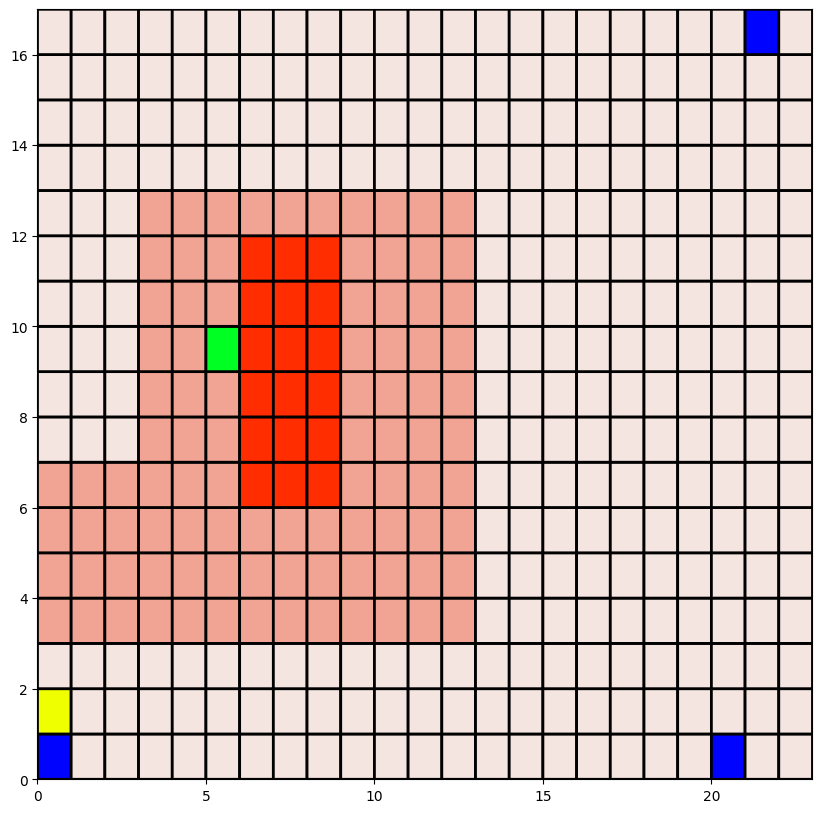

In [36]:
world = 'grid_world2.txt'
goal_reward = 100
start_states = [(0,0), (0,20), (16,21)]
goal_states=[(9,5)]
max_steps=10000

from grid_world import GridWorldEnv, GridWorldWindyEnv

env = GridWorldEnv(world, goal_reward=goal_reward, start_states=start_states, goal_states=goal_states,
                max_steps=max_steps, action_fail_prob=0.2)
plt.figure(figsize=(10, 10))
# Go UP
env.step(UP)
env.render(ax=plt, render_agent=True)

### Legend
- <span style="color:#0004FF">*Blue*</span> is the **start state**.
- <span style="color:#00FF23">*Green*</span> is the **goal state**.
- <span style="color:#F0FF00">*Yellow*</span> is current **state of the agent**.
- <span style="color:#FF2D00">*Redness*</span> denotes the extent of **negative reward**.

### Q values
We can use a 3D array to represent Q values. The first two indices are X, Y coordinates and last index is the action.

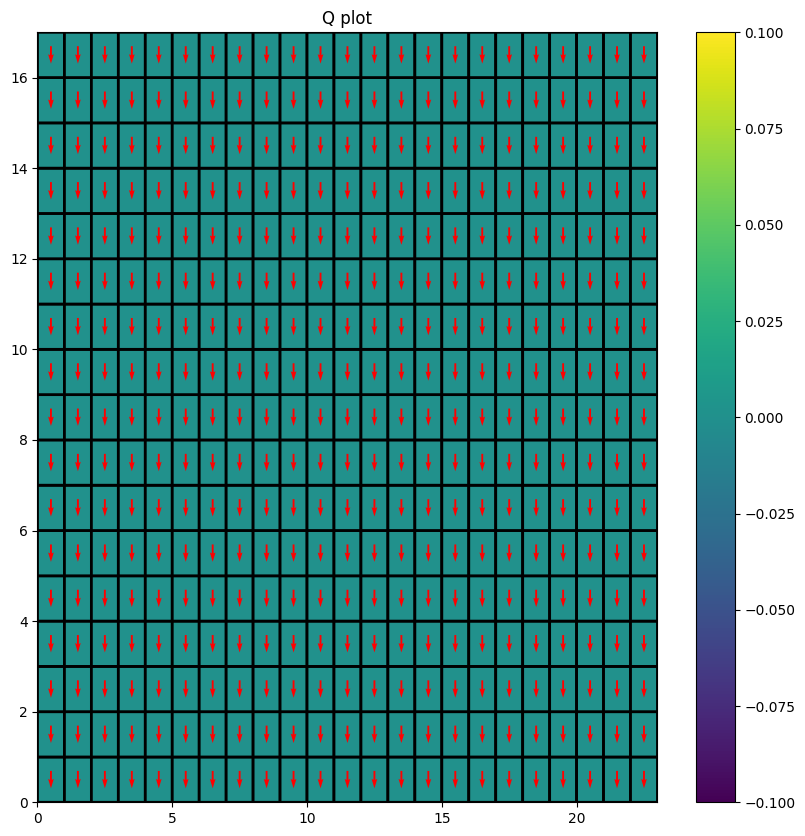

(17, 23, 4)

In [37]:
from grid_world import plot_Q

Q = np.zeros((env.grid.shape[0], env.grid.shape[1], len(env.action_space)))

plot_Q(Q)

Q.shape

### Exploration strategies
1. Epsilon-greedy
2. Softmax

In [39]:
from scipy.special import softmax

seed = 42
rg = np.random.RandomState(seed)

# Epsilon greedy
def choose_action_epsilon(Q, state, epsilon, rg=rg):
    if not Q[state[0], state[1]].any() or rg.rand() < epsilon:  # If no knowledge or under epsilon probability
        return rg.choice(len(Q[state[0], state[1]]))  # Return random action
    else:
        return np.argmax(Q[state[0], state[1]])  # Return best action based on Q values

# Softmax
def softmax(values):
    exp_values = np.exp(values - np.max(values))  # Subtract max for numerical stability
    probabilities = exp_values / np.sum(exp_values)
    return probabilities

def choose_action_softmax(Q, state, rg=rg):
    action_probabilities = softmax(Q[state[0], state[1]])  # Use the custom softmax function
    return rg.choice(a=len(action_probabilities), p=action_probabilities)  # Sample an action based on the softmax probabilities

## SARSA
Now we implement the SARSA algorithm.

Recall the update rule for SARSA:
\begin{equation}
Q(s_t,a_t) \leftarrow  Q(s_t, a_t) + \alpha[r_t + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t)]
\end{equation}

### Hyperparameters

So we have som hyperparameters for the algorithm:
- $\alpha$
- number of *episodes*.
- $\epsilon$: For epsilon greedy exploration

In [40]:
# initialize Q-value
Q = np.zeros((env.grid.shape[0], env.grid.shape[1], len(env.action_space)))

alpha0 = 0.4
gamma = 0.9
episodes = 10000
epsilon0 = 0.1

Let's implement SARSA

In [41]:
print_freq = 100

def sarsa(env, Q, gamma = 0.9, plot_heat = False, choose_action = choose_action_softmax):

    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    if plot_heat:
        clear_output(wait=True)
        plot_Q(Q)
    epsilon = epsilon0
    alpha = alpha0
    for ep in tqdm(range(episodes)):
        tot_reward, steps = 0, 0

        # Reset environment
        state = env.reset()
        action = choose_action(Q, state)
        done = False
        while not done:
            state_next, reward, done = env.step(action)
            action_next = choose_action(Q, state_next)

            # TODO: update equation
            # SARSA Update Equation
            Q[state[0], state[1], action] += alpha * (reward + gamma * Q[state_next[0], state_next[1], action_next] - Q[state[0], state[1], action])
            tot_reward += reward
            steps += 1

            state, action = state_next, action_next

        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps

        if (ep+1)%print_freq == 0 and plot_heat:
            clear_output(wait=True)
            plot_Q(Q, message = "Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f"%(ep+1, np.mean(episode_rewards[ep-print_freq+1:ep]),
                                                                           np.mean(steps_to_completion[ep-print_freq+1:ep]),
                                                                           Q.max(), Q.min()))

    return Q, episode_rewards, steps_to_completion

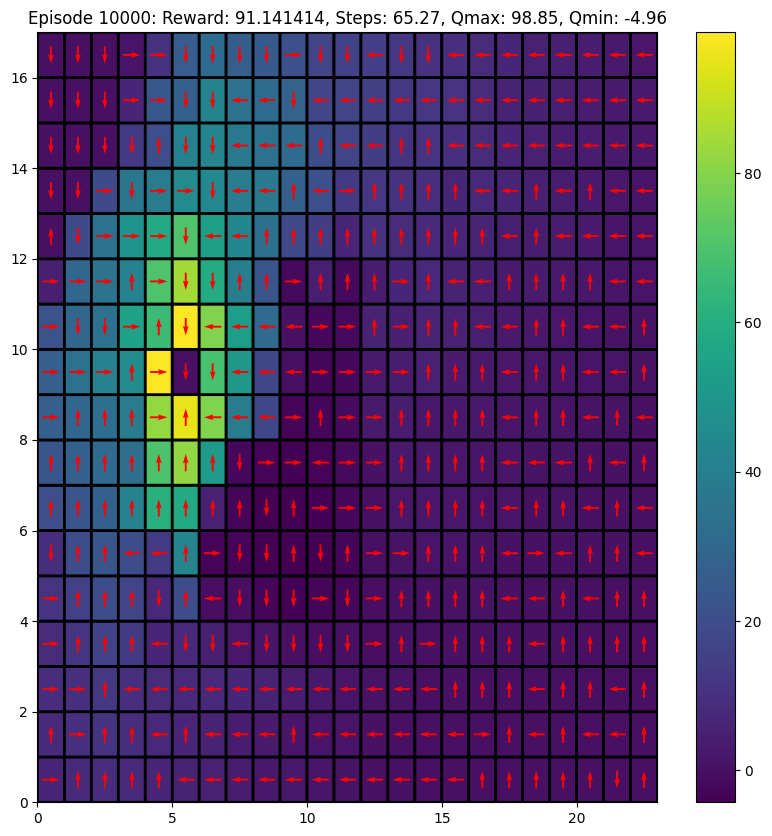

100%|██████████| 10000/10000 [02:32<00:00, 65.46it/s]


In [42]:
Q, rewards, steps = sarsa(env, Q, gamma = gamma, plot_heat=True, choose_action= choose_action_softmax)

In [46]:
# choose_action_epsilonprint_freq = 100
def sarsa(env, Q, gamma = 0.9, plot_heat = False, choose_action = choose_action_softmax):

    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    if plot_heat:
        clear_output(wait=True)
        plot_Q(Q)
    epsilon = epsilon0
    alpha = alpha0
    for ep in tqdm(range(episodes)):
        tot_reward, steps = 0, 0

        # Reset environment
        state = env.reset()
        action = choose_action(Q, state, epsilon0)
        done = False
        while not done:
            state_next, reward, done = env.step(action)
            action_next = choose_action(Q, state_next, epsilon0)

            # TODO: update equation
            # SARSA Update Equation
            Q[state[0], state[1], action] += alpha * (reward + gamma * Q[state_next[0], state_next[1], action_next] - Q[state[0], state[1], action])
            tot_reward += reward
            steps += 1

            state, action = state_next, action_next

        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps

        if (ep+1)%print_freq == 0 and plot_heat:
            clear_output(wait=True)
            plot_Q(Q, message = "Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f"%(ep+1, np.mean(episode_rewards[ep-print_freq+1:ep]),
                                                                           np.mean(steps_to_completion[ep-print_freq+1:ep]),
                                                                           Q.max(), Q.min()))

    return Q, episode_rewards, steps_to_completion

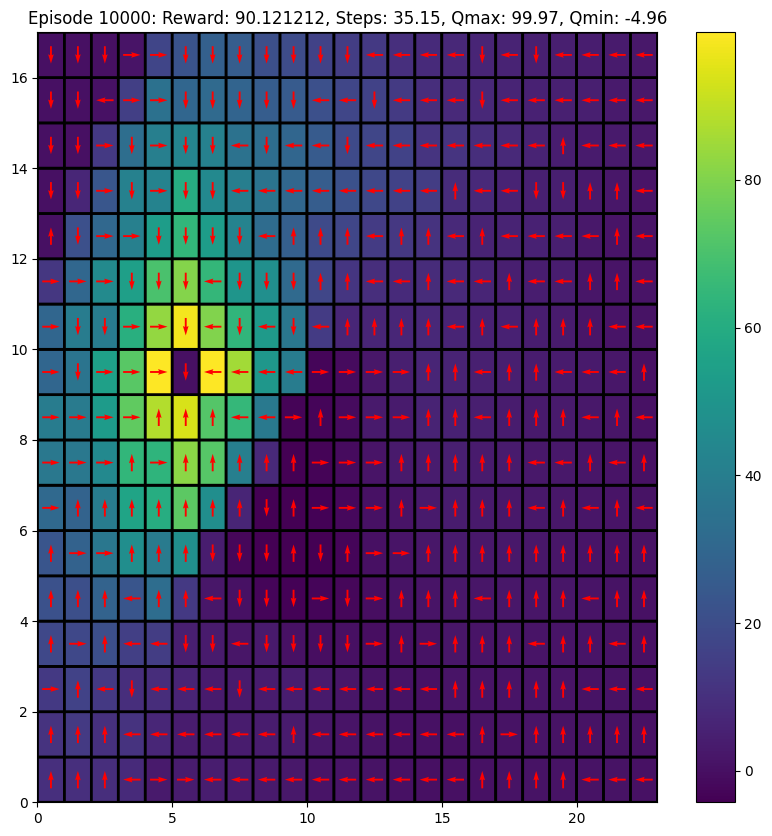

100%|██████████| 10000/10000 [01:11<00:00, 139.14it/s]


In [47]:
Q, rewards, steps = sarsa(env, Q, gamma = gamma, plot_heat=True, choose_action= choose_action_epsilon)

### Visualizing the policy
Now let's see the agent in action.
Run the below cell (as many times) to render the policy;

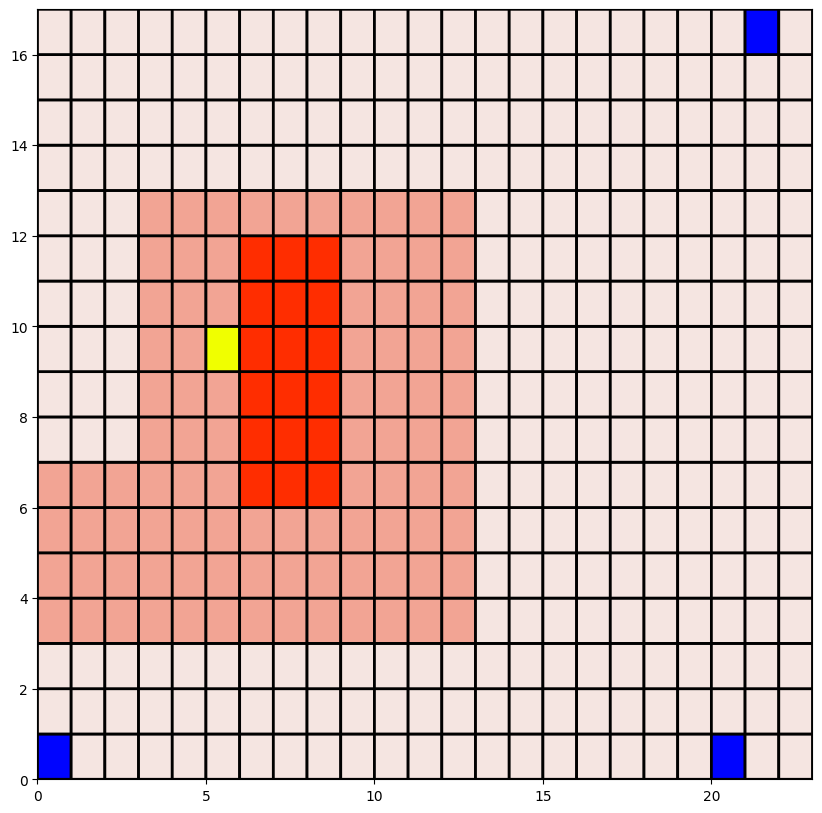

Steps: 38, Total Reward: 95


In [48]:
from time import sleep

state = env.reset()
done = False
steps = 0
tot_reward = 0
while not done:
    clear_output(wait=True)
    state, reward, done = env.step(Q[state[0], state[1]].argmax())
    plt.figure(figsize=(10, 10))
    env.render(ax=plt, render_agent=True)
    plt.show()
    steps += 1
    tot_reward += reward
    sleep(0.2)
print("Steps: %d, Total Reward: %d"%(steps, tot_reward))

### Analyzing performance of the policy
We use two metrics to analyze the policies:

1. Average steps to reach the goal
2. Total rewards from the episode

To ensure, we account for randomness in environment and algorithm (say when using epsilon-greedy exploration), we run the algorithm for multiple times and use the average of values over all runs.

In [24]:
num_expts = 5
reward_avgs, steps_avgs = [], []

for i in range(num_expts):
    print("Experiment: %d" % (i + 1))
    Q = np.zeros((env.grid.shape[0], env.grid.shape[1], len(env.action_space)))
    rg = np.random.RandomState(i)

    # Run SARSA and store metrics
    _, episode_rewards, steps_to_completion = sarsa(env, Q, gamma=gamma, plot_heat=False, choose_action=choose_action_softmax)

    # Store the metrics for each experiment
    reward_avgs.append(episode_rewards)
    steps_avgs.append(steps_to_completion)

Experiment: 1


100%|██████████| 10000/10000 [00:39<00:00, 255.72it/s]


Experiment: 2


100%|██████████| 10000/10000 [00:49<00:00, 202.44it/s]


Experiment: 3


100%|██████████| 10000/10000 [00:34<00:00, 289.85it/s]


Experiment: 4


100%|██████████| 10000/10000 [00:37<00:00, 264.71it/s]


Experiment: 5


100%|██████████| 10000/10000 [00:37<00:00, 263.92it/s]


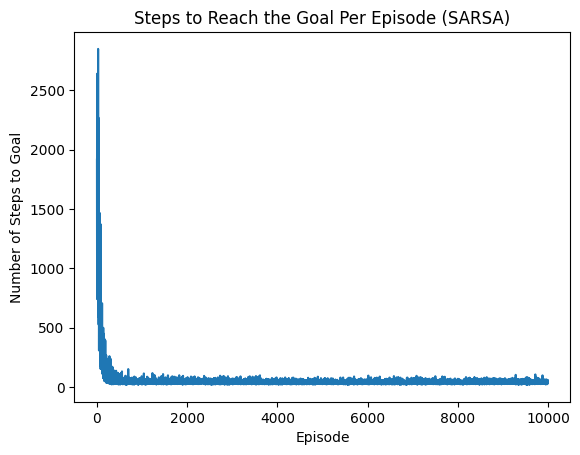

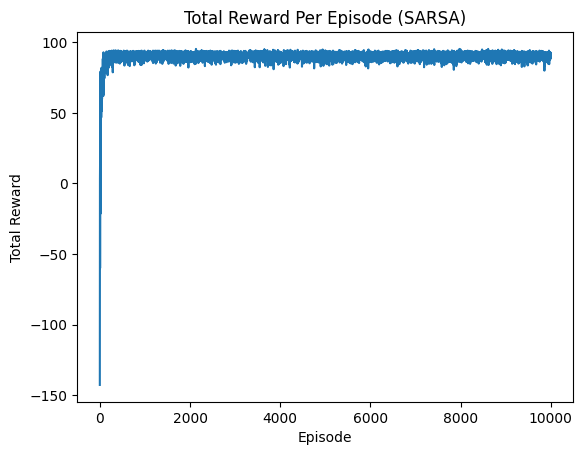

In [25]:
# TODO: visualize individual metrics vs episode count (averaged across multiple run(s))

# Convert lists to numpy arrays for easier averaging
reward_avgs = np.array(reward_avgs)
steps_avgs = np.array(steps_avgs)

# Calculate the average metrics across all experiments
avg_rewards_per_episode = np.mean(reward_avgs, axis=0)
avg_steps_per_episode = np.mean(steps_avgs, axis=0)

# Visualize number of steps to reach the goal
plt.figure()
plt.plot(avg_steps_per_episode)
plt.xlabel('Episode')
plt.ylabel('Number of Steps to Goal')
plt.title('Steps to Reach the Goal Per Episode (SARSA)')
plt.show()

# Visualize  total rewards per episode
plt.figure()
plt.plot(avg_rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward Per Episode (SARSA)')
plt.show()

## Q-Learning
Now, implement the Q-Learning algorithm as an exercise.

Recall the update rule for Q-Learning:
\begin{equation}
Q(s_t,a_t) \leftarrow  Q(s_t, a_t) + \alpha[r_t + \gamma \max_a Q(s_{t+1}, a) - Q(s_t, a_t)]
\end{equation}

Visualize and compare results with SARSA.

In [26]:
# initialize Q-value
Q = np.zeros((env.grid.shape[0], env.grid.shape[1], len(env.action_space)))

alpha0 = 0.4
gamma = 0.9
episodes = 10000
epsilon0 = 0.1

In [27]:
print_freq = 100

def qlearning(env, Q, gamma = 0.9, plot_heat = False, choose_action = choose_action_softmax):

    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    if plot_heat:
        clear_output(wait=True)
        plot_Q(Q)
    epsilon = epsilon0
    alpha = alpha0
    for ep in tqdm(range(episodes)):
        tot_reward, steps = 0, 0

        # Reset environment
        state = env.reset()
        action = choose_action(Q, state)
        done = False
        while not done:
            state_next, reward, done = env.step(action)
            action_next = choose_action(Q, state_next)

            # TODO: update equation
            # Q-Learning Update Equation
            Q[state[0], state[1], action] += alpha * (reward + gamma * np.max(Q[state_next[0], state_next[1]]) - Q[state[0], state[1], action])

            tot_reward += reward
            steps += 1

            state, action = state_next, action_next

        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps

        if (ep+1)%print_freq == 0 and plot_heat:
            clear_output(wait=True)
            plot_Q(Q, message = "Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f"%(ep+1, np.mean(episode_rewards[ep-print_freq+1:ep]),
                                                                           np.mean(steps_to_completion[ep-print_freq+1:ep]),
                                                                           Q.max(), Q.min()))

    return Q, episode_rewards, steps_to_completion

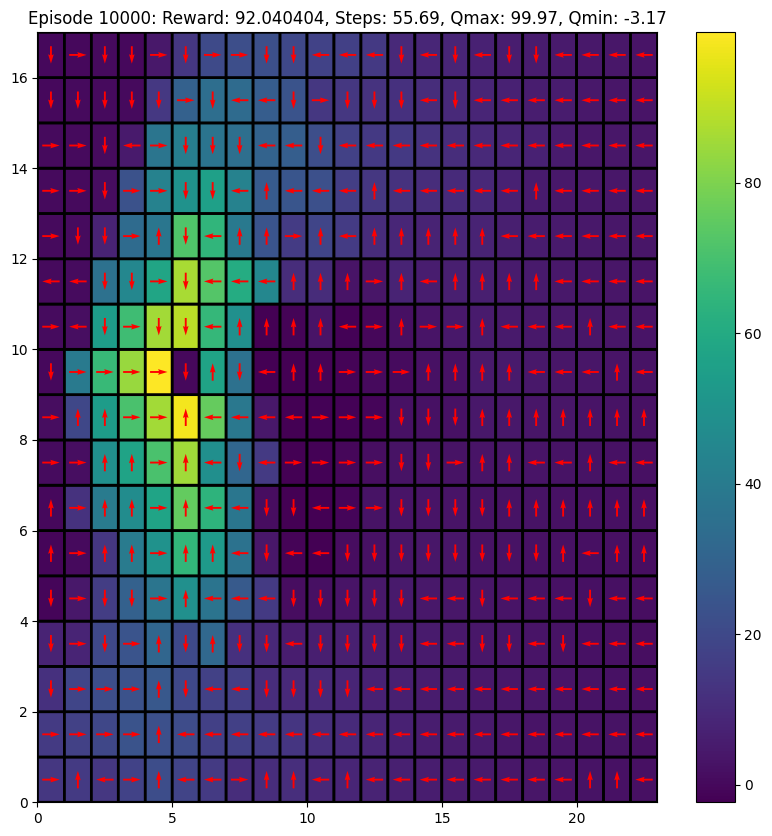

100%|██████████| 10000/10000 [01:27<00:00, 113.71it/s]


In [28]:
Q, rewards, steps = qlearning(env, Q, gamma = gamma, plot_heat=True, choose_action= choose_action_softmax)

In [49]:
print_freq = 100

def qlearning(env, Q, gamma = 0.9, plot_heat = False, choose_action = choose_action_softmax):

    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    if plot_heat:
        clear_output(wait=True)
        plot_Q(Q)
    epsilon = epsilon0
    alpha = alpha0
    for ep in tqdm(range(episodes)):
        tot_reward, steps = 0, 0

        # Reset environment
        state = env.reset()
        action = choose_action(Q, state,epsilon0)
        done = False
        while not done:
            state_next, reward, done = env.step(action)
            action_next = choose_action(Q, state_next, epsilon0)

            # TODO: update equation
            # Q-Learning Update Equation
            Q[state[0], state[1], action] += alpha * (reward + gamma * np.max(Q[state_next[0], state_next[1]]) - Q[state[0], state[1], action])

            tot_reward += reward
            steps += 1

            state, action = state_next, action_next

        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps

        if (ep+1)%print_freq == 0 and plot_heat:
            clear_output(wait=True)
            plot_Q(Q, message = "Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f"%(ep+1, np.mean(episode_rewards[ep-print_freq+1:ep]),
                                                                           np.mean(steps_to_completion[ep-print_freq+1:ep]),
                                                                           Q.max(), Q.min()))

    return Q, episode_rewards, steps_to_completion

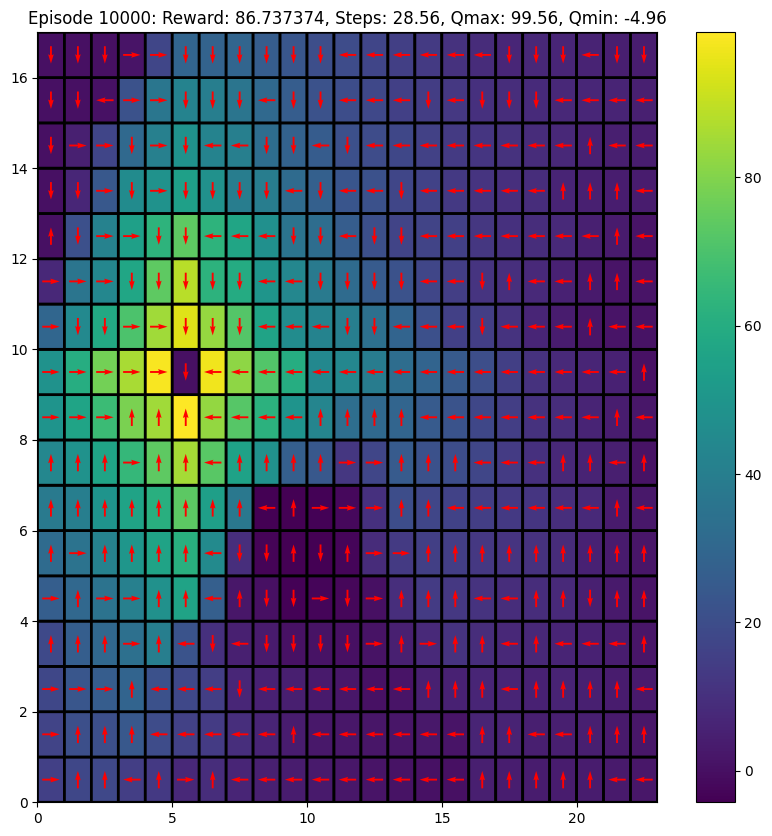

100%|██████████| 10000/10000 [01:07<00:00, 147.87it/s]


In [50]:
Q, rewards, steps = qlearning(env, Q, gamma = gamma, plot_heat=True, choose_action= choose_action_epsilon)

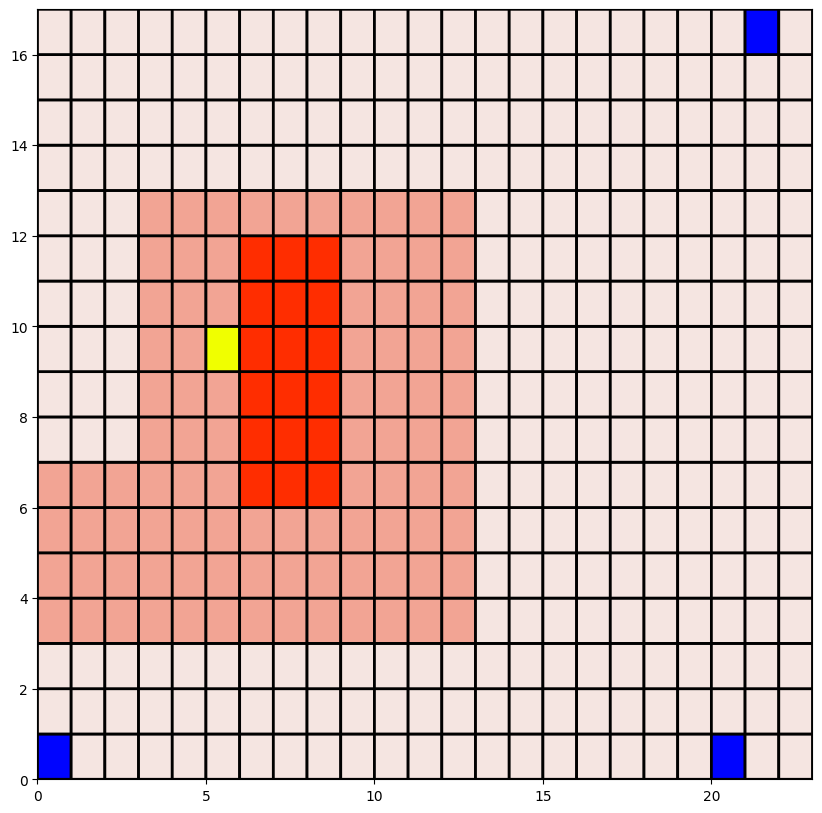

Steps: 16, Total Reward: 90


In [29]:
from time import sleep

state = env.reset()
done = False
steps = 0
tot_reward = 0
while not done:
    clear_output(wait=True)
    state, reward, done = env.step(Q[state[0], state[1]].argmax())
    plt.figure(figsize=(10, 10))
    env.render(ax=plt, render_agent=True)
    plt.show()
    steps += 1
    tot_reward += reward
    sleep(0.2)
print("Steps: %d, Total Reward: %d"%(steps, tot_reward))

In [30]:
num_expts = 5
reward_avgs, steps_avgs = [], []

for i in range(num_expts):
    print("Experiment: %d" % (i + 1))
    Q = np.zeros((env.grid.shape[0], env.grid.shape[1], len(env.action_space)))
    rg = np.random.RandomState(i)

    # Run qlearning and store metrics
    Q, episode_rewards, steps_to_completion = qlearning(env, Q, gamma=gamma, plot_heat=False, choose_action=choose_action_softmax)

    # Append the results for averaging later
    reward_avgs.append(episode_rewards)
    steps_avgs.append(steps_to_completion)

Experiment: 1


100%|██████████| 10000/10000 [01:29<00:00, 111.61it/s]


Experiment: 2


100%|██████████| 10000/10000 [01:01<00:00, 161.99it/s]


Experiment: 3


100%|██████████| 10000/10000 [01:03<00:00, 156.53it/s]


Experiment: 4


100%|██████████| 10000/10000 [00:37<00:00, 263.87it/s]


Experiment: 5


100%|██████████| 10000/10000 [00:52<00:00, 190.26it/s]


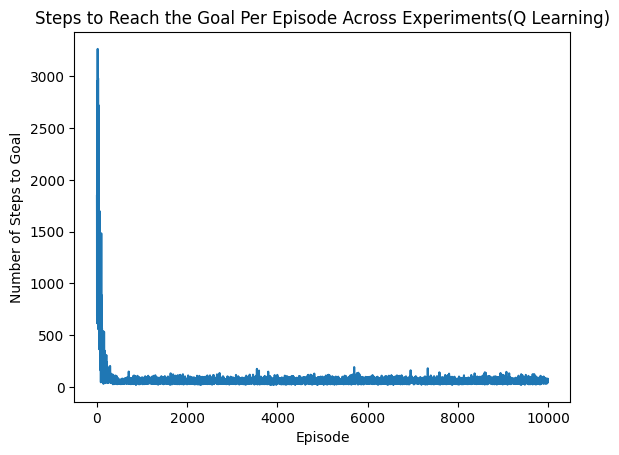

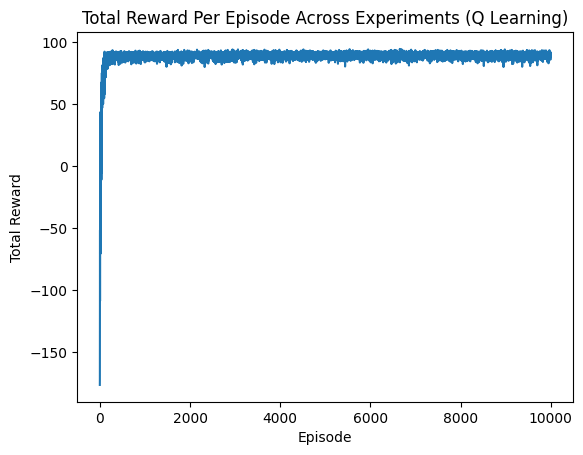

In [31]:
# TODO: visualize individual metrics vs episode count (averaged across multiple run(s))

# Convert lists to numpy arrays for easier calculation of mean
reward_avgs = np.array(reward_avgs)
steps_avgs = np.array(steps_avgs)

# Calculate the mean across all experiments
mean_rewards = np.mean(reward_avgs, axis=0)
mean_steps = np.mean(steps_avgs, axis=0)

# Visualize average number of steps to reach the goal
plt.figure()
plt.plot(mean_steps)
plt.xlabel('Episode')
plt.ylabel('Number of Steps to Goal')
plt.title('Steps to Reach the Goal Per Episode Across Experiments(Q Learning)')
plt.show()

# Visualize average total rewards per episode
plt.figure()
plt.plot(mean_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward Per Episode Across Experiments (Q Learning)')
plt.show()

### TODO: What differences do you observe between the policies learnt by Q Learning and SARSA (if any).

#### Observations:

- **Convergence Speed**: The "Steps to Reach the Goal" plots for both SARSA and Q-Learning show a steep decline early in training, indicating that both algorithms are learning efficiently. However, the Q-Learning plot shows a slightly more gradual decrease compared to the SARSA plot, which could suggest that SARSA converges to a policy requiring fewer steps more quickly than Q-Learning.

- **Total Reward Stability**: The "Total Reward Per Episode" plots for SARSA and Q-Learning both level off to a relatively stable value after the initial episodes. This indicates that both algorithms achieve a stable policy as the number of episodes increases. The stable total reward suggests that both algorithms are finding a balance between exploring the environment and exploiting known information to maximize rewards.

- **Variability in Learning**: Although both algorithms show a decrease in the number of steps to the goal and an increase in total rewards over time, the variability in these metrics across episodes appears to be lower for Q-Learning than for SARSA. This could imply that Q-Learning is learning a more consistent policy.

- **Approach to Exploration**: SARSA and Q-Learning differ in how they handle exploration. SARSA, which includes the next action in the update rule (hence accounting for the current policy's exploration), typically learns a more conservative policy. Q-Learning, on the other hand, assumes the next action will be optimal, potentially leading to a more aggressive policy that may perform better in the long run but with higher initial variability.

- **Policy Differences**: The total reward plots suggest that the policies learned by Q-Learning and SARSA converge to a similar performance level. However, the steps to reach the goal suggest that the SARSA policy may be more cautious, potentially taking more steps to avoid negative rewards, whereas the Q-Learning policy might be taking more risks initially but then settles into an efficient path to the goal.

- **Impact of Exploration and Exploitation**: The graphs reflect the impact of exploration-exploitation balance in reinforcement learning. Initially, both algorithms explore the environment, resulting in lower rewards and more steps per episode. As learning progresses, exploitation begins to dominate, improving the efficiency of the learned policy as seen in the graphs.

**`In conclusion, while both algorithms improve performance over time, SARSA seems to learn slightly faster and more conservatively, while Q-Learning seems to learn a more optimal policy but with potentially more risk of large negative rewards early in training. The ultimate choice between SARSA and Q-Learning may depend on the specific requirements of the task, such as whether quick convergence or optimal long-term rewards is more important.`**

In [ ]:
!pip install nbconvert
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

In [ ]:
!jupyter nbconvert --to html "/content/drive/MyDrive/Colab Notebooks/CS6700_Tutorial_4_QLearning_SARSA_ROLLNUMBER.ipynb"